In [1]:
from pyNN.random import RandomDistribution, NumpyRNG
from pyNN import neuron
import pyNN.space as space
import pyNN
import pyNN.neuron as sim
import numpy as np
from pyNN.utility.plotting import Figure, Panel
from pyNN.space import Grid2D, RandomStructure, Sphere
import matplotlib.pyplot as plt
from neuroml import Morphology, Segment, Point3DWithDiam as P
from pyNN.morphology import NeuroMLMorphology, NeuriteDistribution, Morphology as Morph, IonChannelDistribution
from pyNN.neuron.morphology import uniform, random_section, random_placement, at_distances, apical_dendrites, dendrites, centre
from pyNN.parameters import IonicSpecies
from pyNN.standardmodels import StandardIonChannelModel, build_translations
from pyNN.neuron import NativeCellType
import shutil
import os
from neuron import h, nrn, hclass
from pyNN.utility.build import compile_nmodl
from pyNN.standardmodels.cells import MultiCompartmentNeuron as mc
import platform

c:\Users\rebek\Modelo-Motoneuronio\modelpynn\lib\site-packages\pyNN\neuron\__init__.py:14: UserWarning: mpi4py not available
  warnings.warn("mpi4py not available")


Configuração para os sistemas, compilação e carregamento de um arquivo de modelo (mn.mod) em um ambiente de simulação de redes neurais utilizando o pacote PyNN com o mecanismo de simulação NEURON

In [2]:
if platform.system() == 'Linux':
    shutil.copyfile('mn.mod','modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/mn.mod')
    compile_nmodl('modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/')
    h.nrn_load_dll('modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/mn.o')
if platform.system() == 'Windows':
    shutil.copyfile('mn.mod','modelpynn/Lib/site-packages/pyNN/neuron/nmodl/mn.mod')
    compile_nmodl('modelpynn/Lib/site-packages/pyNN/neuron/nmodl')
    h.nrn_load_dll('modelpynn/Lib/site-packages/pyNN/neuron/nmodl/mn.o')


nrnivmodl found at c:\neuron\bin\nrnivmodl
Successfully compiled NEURON extensions.


Instalção canais de potassio 

In [3]:
class KsChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12, #uniform('all', 0.12),
        "e_rev": -80,
        "vt": -57.65
    }
    
    translations = build_translations(
        ('conductance_density', 'gk_slow'),
        ('e_rev', 'eks'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'p': ('motoneuron', 'p'),
    }
    default_initial_values = {
        'p': 1,  # initial value for gating variable m
    }
    units = {
        'iks': 'mA/cm2',
        'p': 'dimensionless',
    }
    recordable = ['iks','p']
    model = "motoneuron"
    conductance_density_parameter = 'gk_slow'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

Instalção canais de potassio rapido

In [4]:
class KfChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12, #uniform('all', 0.12),
        "e_rev": -80,
        "vt": -57.65
    }
    
    recordable = ['ikf','n'] 
    translations = build_translations(
        ('conductance_density', 'gk_fast'),
        ('e_rev', 'ekf'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'n': ('motoneuron', 'n'),
    }
    default_initial_values = {
        'n': 1,  # initial value for gating variable m
    }
    units = {
        'ikf': 'mA/cm2',
        'n': 'dimensionless',
    }
    model = "motoneuron"
    conductance_density_parameter = 'gk_fast'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

Instalção canais de sódio

In [5]:
class NaChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12, #uniform('all', 0.12),
        "e_rev": 50,
        "vt":-57.65,
    }
    
    default_initial_values = {
        'm': 1.0,  # initial value for gating variable m
        'h': 0.0,  # initial value for gating variable h
    }
    recordable = ['ina', 'm', 'h']
    units = {
        'ina': 'mA/cm2',
        'm': 'dimensionless',
        'h': 'dimensionless',
    }
    translations = build_translations(
        ('conductance_density', 'gna'),
        ('e_rev', 'ena'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'h': ('motoneuron', 'h'),
        'm': ('motoneuron', 'm'),
        'ina': ('motoneuron', 'ina'),
    }
    model = "motoneuron"
    conductance_density_parameter = 'gna'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

A classe PassiveLeak modela um canal iônico de vazamento passivo, que é um tipo de canal que permite a passagem constante de íons através da membrana celular, independentemente do estado da célula (ou seja, não depende de voltagem ou de outras variáveis de estado para sua abertura ou fechamento).

In [6]:
class PassiveLeak(StandardIonChannelModel):
    translations = build_translations(
        ('conductance_density', 'gl'),
        ('e_rev', 'el'),
    )
    variable_translations = {}
    model = "motoneuron"
    conductance_density_parameter = 'gl'

Modelo uma célula neuronal usando segmentos(soma e dendritos) para definir a morfologia do neurônio. 
Uso da classe cell_class para configurar o neurônio com diferentes canais iônicos e propriedades. 

In [7]:
n=100
def create_somas(n):
    somas = []
    for i in range(n):
        diameter = 77.5 + i * ((82.5-77.5)/n)
        soma= Segment(proximal=P(x=diameter, y=0, z=0, diameter=diameter),
                       distal=P(x=0, y=0, z=0, diameter=diameter),
                       name="soma", id=i)
        somas.append(soma)
    return somas

def create_dends(n,somas):
     dends=[]
     for i in range(n):
        y = 18- i * (18/n)
        diameter = 41.5 + i * ((62.5-41.5)/n)
        x_distal= -5500 + i * ((-6789+5500)/n)
        dend = Segment(proximal=P(x=0, y=y, z=0, diameter=diameter),
               distal=P(x=x_distal, y=y, z=0, diameter=diameter),
               name="dendrite",
               parent=somas[i], id=i)
        dends.append(dend)
     return dends

def soma_dend(somas, dends):
    combined= []
    first_soma = somas[0]
    for i in range(len(dends)):
        combineds=NeuroMLMorphology(Morphology(segments=(somas[i], 
                                                dends[i])))
        combined.append(combineds)
    return combined

somas= create_somas(n)
dendrites = create_dends(n,somas)
neurons= soma_dend(somas, dendrites)
neurons
len(neurons)
len(somas)
len(dendrites)

100

In [8]:

class cell_class(sim.MultiCompartmentNeuron):
    def __init__(self, **parameters):

        self.label = "mn1"
        self.ion_channels = {'pas_soma': PassiveLeak, 'pas_dend': sim.PassiveLeak,
                           'na': NaChannel, 'kf': KfChannel, 'ks': KsChannel}
        self.units = {'v':'mV',
                      'gsyn_exc': 'uS',
                      'gsyn_inh': 'uS',
                      'na.m': 'dimensionless', 'na.h': 'dimensionless', 'kf.n': 'dimensionless', 
                      'ks.p': 'dimensionless', 'na.ina': 'mA/cm2', 'kf.ikf': 'mA/cm2', 
                      'ks.iks': 'mA/cm2'}
        self.post_synaptic_entities = {'syn': sim.CondExpPostSynapticResponse}
        
        super(cell_class, self).__init__(**parameters)
    

O código define uma atribuição cell_class chamada cell_type, configurando a morfologia, propriedades elétricas, canais iônicos e sinapses do neurônio.

In [9]:

cell_type = cell_class(
    morphology= neurons,
    cm=1,    # mF / cm**2
    Ra=0.070, # ohm.mm
    ionic_species={"na": IonicSpecies("na", reversal_potential=50),
                   "ks": IonicSpecies("ks", reversal_potential=-80),
                   "kf": IonicSpecies("kf", reversal_potential=-80)
                  },
    pas_soma = {"conductance_density": uniform('soma', 7e-4), "e_rev":-70},
    pas_dend = {"conductance_density": uniform('dendrite', 7e-4), "e_rev":-70},
    na = {"conductance_density": uniform('soma', 10), "vt":list(np.linspace(-57.65, -53,100))},
    kf = {"conductance_density": uniform('soma', 1), "vt":list(np.linspace(-57.65, -53,100))},
    ks = {"conductance_density": uniform('soma', 0.5), "vt":list(np.linspace(-57.65, -53,100))},

    syn={
        "locations": centre('dendrite'),
        "e_syn": 0,
        "tau_syn": 0.6},  
)
print(n)

100


Cria uma população de 2 neuronios, com potencial de ação ('v') de -70 mV 

In [10]:
cells = sim.Population(n, cell_type, initial_values={'v': list(-70*np.ones(100))})


KeyError: 1

Acessa os receptores sinapticos da primeira celula 

In [ ]:
cells[0]._cell.synaptic_receptors

{'syn': defaultdict(list, {1: [ExpSyn[0]]})}

Função para gerar tempos de disparos para os neurônios

In [ ]:
def generate_spike_times(i):
    input_rate = 83
    Tf = 100
    number = int(Tf * input_rate / 1000.0)
    gen = lambda: sim.Sequence(np.add.accumulate(np.random.exponential(1000.0 / input_rate, size=number)))
    if hasattr(i, "__len__"):
        return [gen() for j in i]
    else:
        return gen()


Uma população de 400 fontes de disparo é criada, 'sim.Projection' cria projeções de conexões(dendriticas) entre populações de neurônios.A probabilidade de uma conexão ser estabelecida entre dois neurônios (30%).

In [ ]:
np.random.seed(26278342)
spike_source = sim.Population(400, sim.SpikeSourceArray(spike_times=generate_spike_times))
syn = sim.StaticSynapse(weight=0.6, delay=0.2)
input_conns = sim.Projection(spike_source, cells, 
                             sim.FixedProbabilityConnector(0.3, location_selector='dendrite'), 
                             syn, receptor_type="syn")

população de fontes de disparo 

In [ ]:
spike_source

Population(400, SpikeSourceArray(<parameters>), structure=Line(dx=1.0, x0=0.0, y=0.0, z=0.0), label='population1')

Corrente contínua nos neuronios

In [ ]:
step_current_dend = sim.DCSource(amplitude=7000, start=0, stop=50)
#step_current.inject_into(cells[1:2], location=apical_dendrites(fraction_along=0.9))
#step_current.inject_into(cells[1:2], location=random(after_branch_point(3)(apical_dendrites))
# step_current_dend.inject_into(cells[0:2], location='dendrite')

configuração da simulação para registrar vários tipos de dados durante a simulação

In [ ]:
spike_source.record('spikes')
cells.record('spikes')
cells[0:2].record('v', locations=('dendrite','soma'))
cells[0:2].record(('na.m', 'na.h'), locations='soma')
cells[0:2].record(('kf.n'), locations='soma')
cells[0:2].record(('ks.p'), locations='soma')


execução da simulção, com duração de 100 ms

In [ ]:
sim.run(100)

100.00000000001417

Gerar e salvar a figura com os resultados da simulação neural

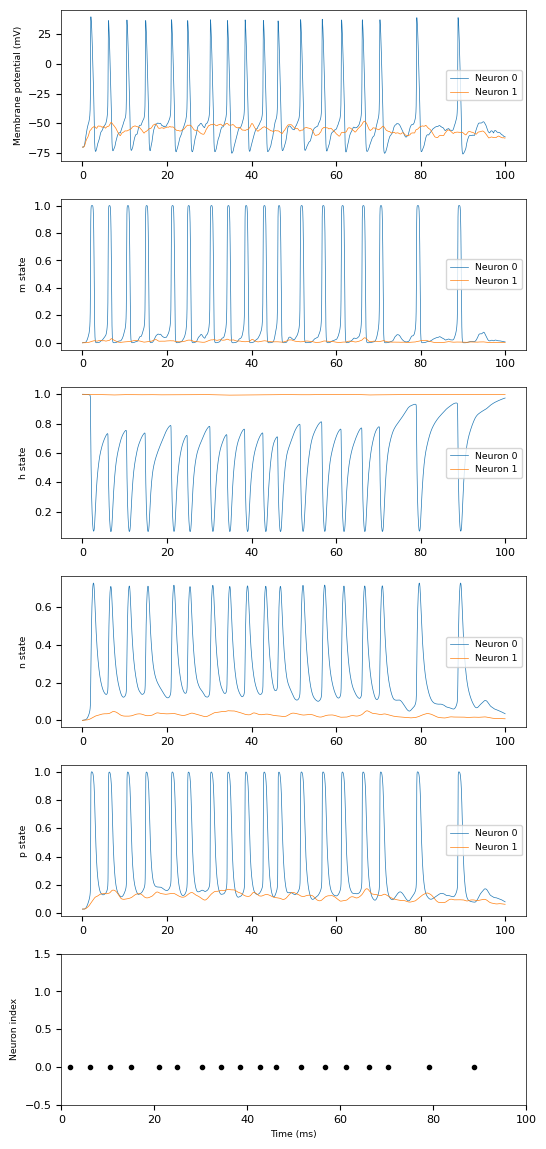

In [ ]:
figure_filename = 'teste.png'

data = cells.get_data().segments[0]
vm = data.filter(name="soma.v")[0]
m = data.filter(name="soma.na.m")[0]
h = data.filter(name="soma.na.h")[0]
n = data.filter(name="soma.kf.n")[0]
p = data.filter(name="soma.ks.p")[0]
# ina = data.filter(name="soma.na.ina")[0]
# ik = data.filter(name="ik")[0]

# gsyn = data.filter(name="gsyn_exc")[0]
Figure(
    Panel(vm, ylabel="Membrane potential (mV)", xticks=True, yticks=True),
    Panel(m, ylabel="m state", xticks=True, yticks=True),
    Panel(h, ylabel="h state", xticks=True, yticks=True),
    Panel(n, ylabel="n state", xticks=True, yticks=True),
    Panel(p, ylabel="p state", xticks=True, yticks=True),
    # Panel(ina, ylabel="i_na (mA)", xticks=True, yticks=True),
    # Panel(ik, ylabel="i_k (mA)", xticks=True, yticks=True),
    
    # Panel(gsyn, ylabel="Synaptic conductance (uS)"),
    Panel(data.spiketrains, xlabel="Time (ms)", xticks=True, yticks=True),
).save(figure_filename)


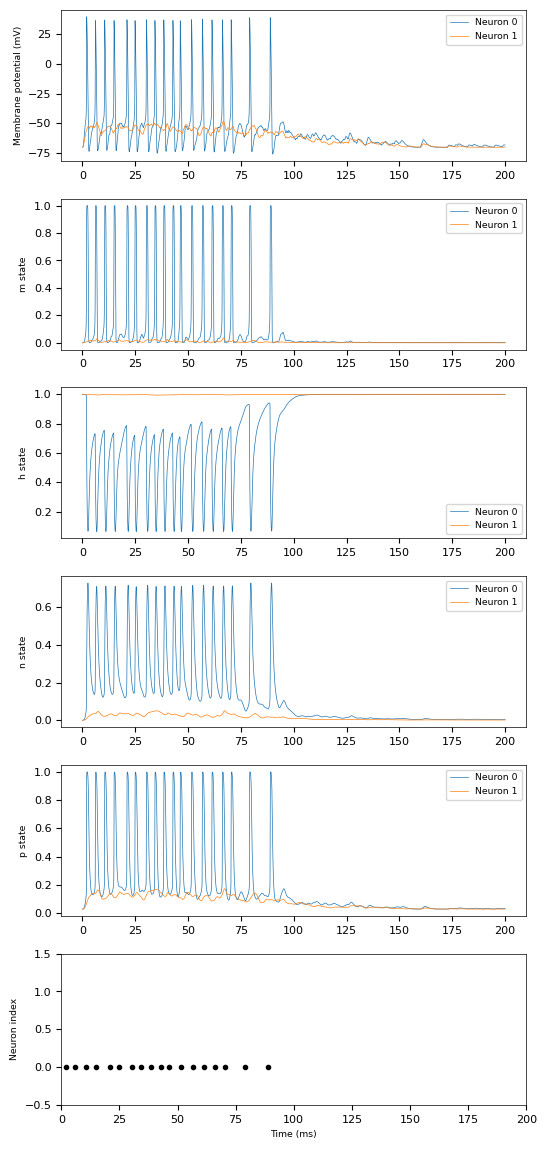

In [ ]:
sim.run(100)
figure_filename = 'teste.png'

data = cells.get_data().segments[0]
vm = data.filter(name="soma.v")[0]
m = data.filter(name="soma.na.m")[0]
h = data.filter(name="soma.na.h")[0]
n = data.filter(name="soma.kf.n")[0]
p = data.filter(name="soma.ks.p")[0]
# ina = data.filter(name="soma.na.ina")[0]
# ik = data.filter(name="ik")[0]

# gsyn = data.filter(name="gsyn_exc")[0]
Figure(
    Panel(vm, ylabel="Membrane potential (mV)", xticks=True, yticks=True),
    Panel(m, ylabel="m state", xticks=True, yticks=True),
    Panel(h, ylabel="h state", xticks=True, yticks=True),
    Panel(n, ylabel="n state", xticks=True, yticks=True),
    Panel(p, ylabel="p state", xticks=True, yticks=True),
    # Panel(ina, ylabel="i_na (mA)", xticks=True, yticks=True),
    # Panel(ik, ylabel="i_k (mA)", xticks=True, yticks=True),
    
    # Panel(gsyn, ylabel="Synaptic conductance (uS)"),
    Panel(data.spiketrains, xlabel="Time (ms)", xticks=True, yticks=True),
).save(figure_filename)